<a href="https://colab.research.google.com/github/pipik217/krystof_pipal_6351088/blob/main/ML_cifar_CNN_exercise_6351088.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install tensorflow
!pip install keras

In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


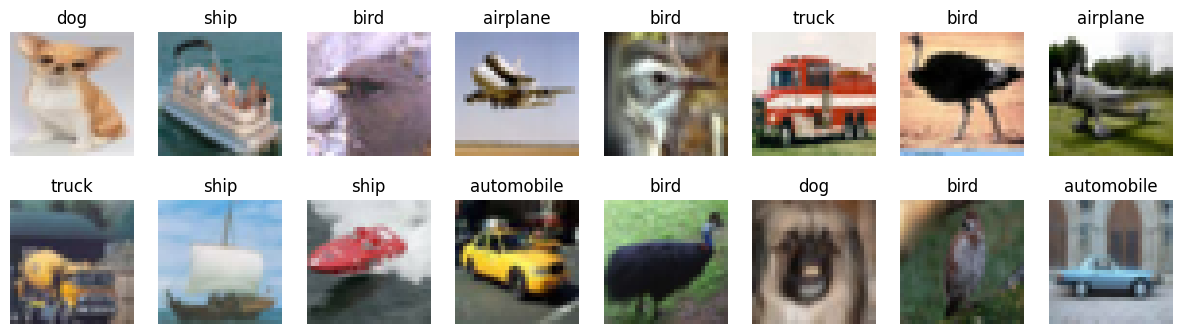

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




#The explanation to each chunk will be given numerically for the code below:

1. Loads the dataset into training and test sets. One-hot encoding is applied to the labels so that they can be used with the categorical_crossentropy loss function.
2. Pixel values are scaled to [0, 1] range to help the model converge faster and perform better. Normalization ensures more stable training and avoids exploding gradients.
3. Generates new training samples by applying random transformations like: Rotation, Translation (shifts), Horizontal flips , Zoom, Helps increase dataset diversity and reduce overfitting by making the model robust to variations.
4. BLOCK1 - 2 Conv2D layers with 32 filters each (3x3 kernel size): extract features like edges, textures, and basic shapes. Padding='same' keeps the spatial dimensions intact. ReLU activation introduces non-linearity.BatchNormalization: Normalizes the output after each convolution to stabilize training. MaxPooling2D: Reduces feature map size from 32x32 to 16x16. Dropout (25%): Randomly deactivates neurons to prevent overfitting.
5. BLOCK2 - Double the number of filters (64): Deeper layers learn more complex features like corners, shapes, or contours. Same structure as block 1 but with higher capacity. MaxPooling reduces from 16x16 → 8x8 feature maps.
Dropout again helps fight overfitting.
6. BLOCK3 - Even deeper: 128 filters. This block extracts the most abstract high-level features — likely parts of objects. Pooling reduces to 4x4 size.
Higher dropout (40%) since overfitting risk increases with more parameters.
7. Flatten: Converts 3D feature maps into a 1D vector (needed for Dense layers). Dense(128): Fully connected layer with 128 neurons — makes high-level decisions. Dropout(50%): Strong regularization. BatchNormalization again helps convergence.
8. Final layer with 10 neurons, one per class. Softmax activation outputs probabilities across the 10 classes — sums to 1.
9. Optimizer: Adam, which adapts the learning rate dynamically. Loss: Categorical Crossentropy for multiclass classification. Metric: Accuracy, to track performance.
10. EarlyStopping halts training if validation loss doesn’t improve for 10 epochs, avoiding overfitting. ReduceLROnPlateau reduces learning rate when progress stalls, allowing finer convergence.
11. Trains the model using augmented data from the generator. Validation data is evaluated after every epoch. Batch size = 64, and up to 100 epochs, but can stop earlier due to early stopping.


In [49]:
#Import necessary packages
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator #real-time data augmentation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #training callbacks to prevent overfitting and fine-tune learning rate dynamically
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

#Load CIFAR-10 dataset [1]
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

#Normalize input images [2]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#Data Augmentation [3]
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

#Build improved CNN model
model = models.Sequential([
    #BLOCK 1 [4]
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    #BLOCK 2 [5]
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    #BLOCK 3 [6]
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    #[7]
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    #[8]
    layers.Dense(10, activation='softmax')
])

#Compile model [9]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Add callbacks [10]
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
]

# Train model [11]
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_test, y_test),
                    epochs=100,
                    callbacks=callbacks)

# Evaluate model
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.3222 - loss: 2.1296 - val_accuracy: 0.5095 - val_loss: 1.4315 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.5362 - loss: 1.2929 - val_accuracy: 0.5840 - val_loss: 1.2247 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6253 - loss: 1.0701 - val_accuracy: 0.6851 - val_loss: 0.9056 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.6658 - loss: 0.9538 - val_accuracy: 0.6874 - val_loss: 0.9113 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.6912 - loss: 0.8872 - val_accuracy: 0.7232 - val_loss: 0.8128 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.7143 - loss: 0.8240 - val_accuracy: 0.7248 - val_loss: 0.8055 - learning_rate: 0.0010
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.7

Shows the model architecture in a nice visual way.

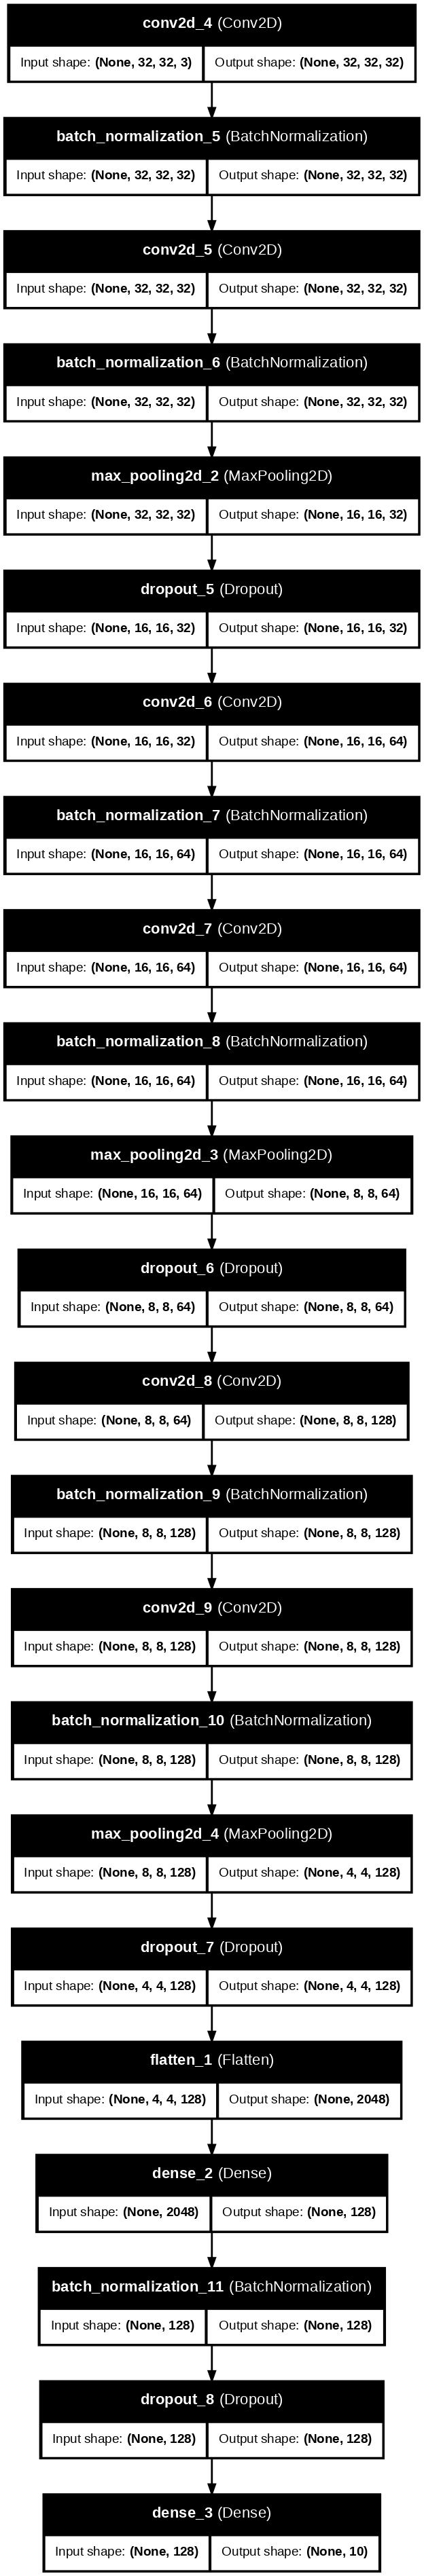

In [48]:
"""
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model

#Generate and save the model architecture plot
plot_model(model, to_file='cnn_model_structure.png', show_shapes=True, show_layer_names=True, dpi=100)
"""

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


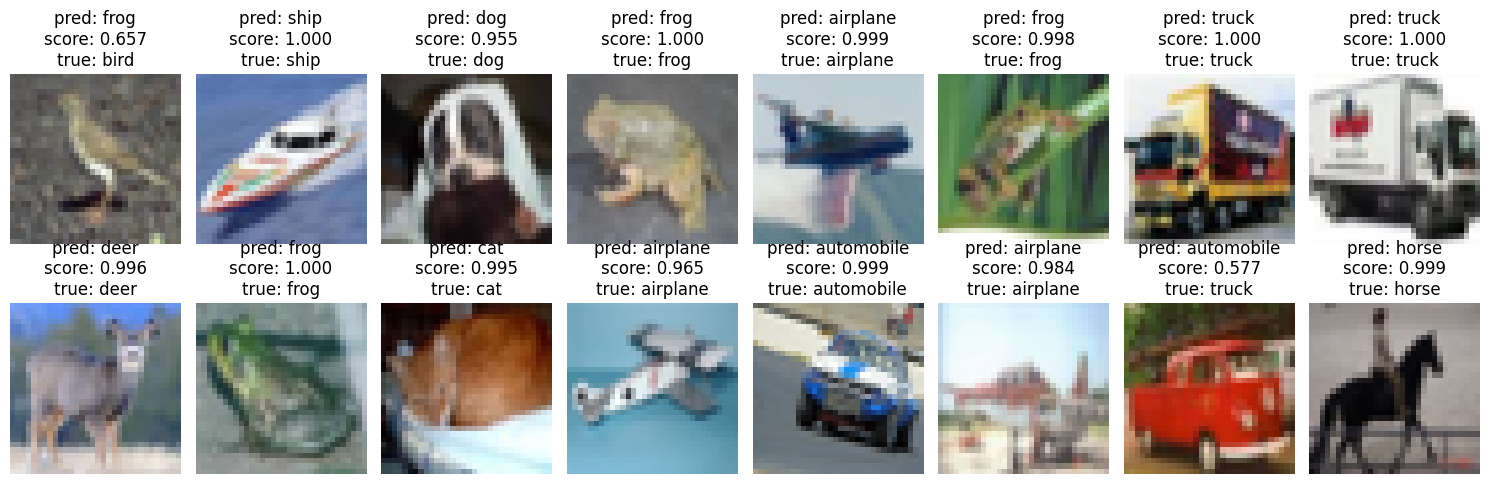

In [50]:
#Recalculate predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_test_index = np.argmax(y_test, axis=1)
else:
    y_test_index = y_test

#Visual inspection plot
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test_index))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(x_test[random_index])

        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[int(y_test_index[random_index])]

        ax.set_title(f"pred: {pred_label}\nscore: {pred_proba:.3f}\ntrue: {true_label}")
plt.tight_layout()
plt.show()


When visually checking what our model ges wrong we can see some patterns, for example smaller looking trucks are analyzed as cars, birds of neutral colours like brown or green are usually mistook for frogs; also weirdly oriented cats.
Maybe in the future it would be useful to add attention mechanisms for specific classes that were predicted less accurately, for example cats and dogs (as can be seen on the confusion matrix below). We could choose specific features that could really differentiate these two.

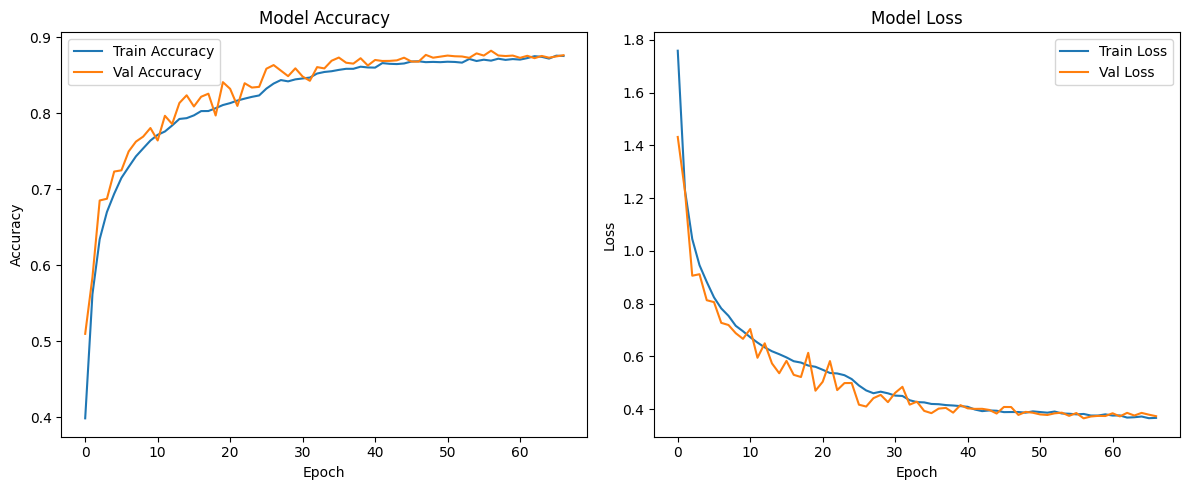

In [51]:
plt.figure(figsize=(12, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


The model is learning well, and generalizes nicely to unseen data. There’s good consistency between training and validation performance. Low risk of overfitting.



In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test_index, y_pred_test_classes, target_names=cifar10_classes))


              precision    recall  f1-score   support

    airplane       0.91      0.89      0.90      1000
  automobile       0.94      0.96      0.95      1000
        bird       0.87      0.83      0.85      1000
         cat       0.84      0.70      0.76      1000
        deer       0.87      0.88      0.88      1000
         dog       0.88      0.79      0.83      1000
        frog       0.80      0.97      0.88      1000
       horse       0.90      0.93      0.91      1000
        ship       0.94      0.93      0.93      1000
       truck       0.89      0.95      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Confirms that the dog and cat classes are the weakest.

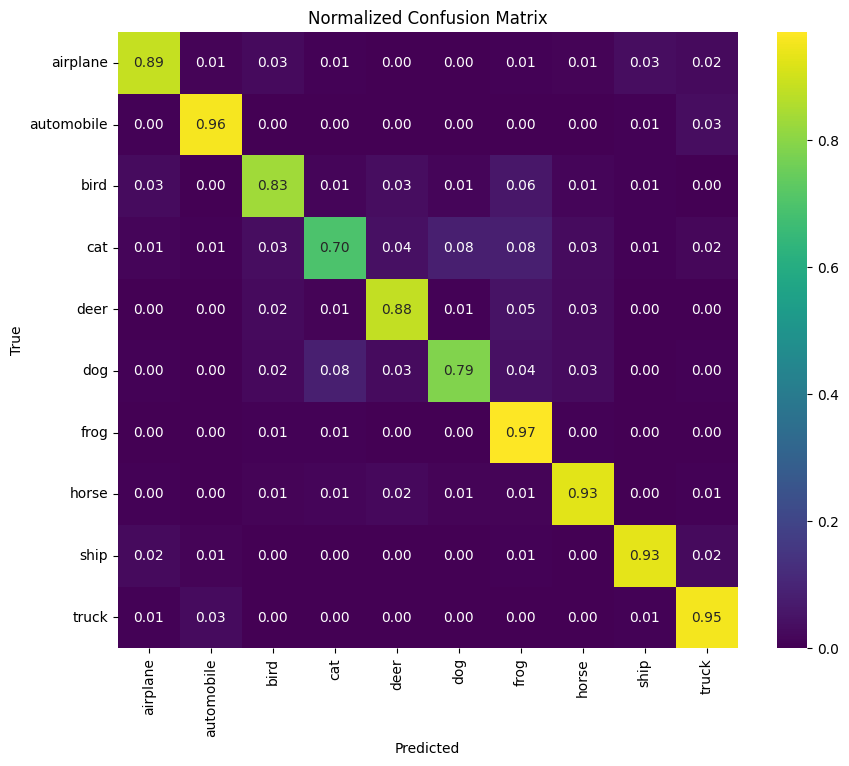

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_index, y_pred_test_classes, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='viridis', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()


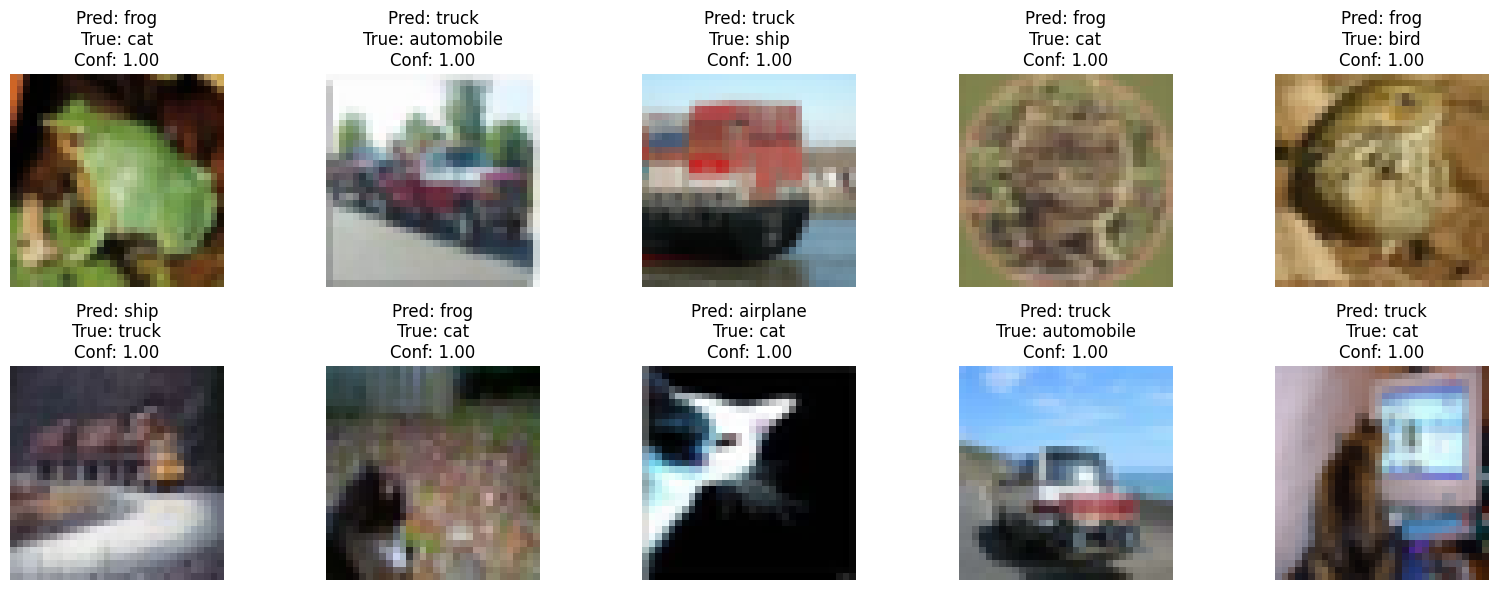

In [54]:
wrong_idx = np.where(y_pred_test_classes != y_test_index)[0]
wrong_confidences = y_pred_test_max_probas[wrong_idx]
sorted_wrong = wrong_idx[np.argsort(-wrong_confidences)]  #Sort by highest confidence wrong predictions

#Show top 10 most confident wrong predictions
fig = plt.figure(figsize=(16, 6))
for i in range(10):
    idx = sorted_wrong[i]
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(x_test[idx])
    ax.axis('off')
    ax.set_title(f"Pred: {cifar10_classes[y_pred_test_classes[idx]]}\nTrue: {cifar10_classes[y_test_index[idx]]}\nConf: {y_pred_test_max_probas[idx]:.2f}")
plt.tight_layout()
plt.show()


In [55]:
class_accuracies = []
for i in range(len(cifar10_classes)):
    class_idx = np.where(y_test_index == i)[0]
    correct = np.sum(y_pred_test_classes[class_idx] == y_test_index[class_idx])
    acc = correct / len(class_idx)
    class_accuracies.append(acc)

for i, acc in enumerate(class_accuracies):
    print(f"{cifar10_classes[i]}: {acc:.2%}")


airplane: 88.60%
automobile: 95.70%
bird: 83.30%
cat: 69.60%
deer: 88.10%
dog: 78.80%
frog: 97.00%
horse: 92.70%
ship: 93.20%
truck: 95.30%
